## Data Preprocessing

In [60]:
# Load in the data from the files
import pandas as pd
# Load the content data
content_df = pd.read_csv('content.csv')
# Load the followers data
followers_df = pd.read_csv('followers.csv')
# Load the visitors data
visitors_df = pd.read_csv('visitors.csv')
# Ensure the 'Date' column is in datetime format
content_df['Date'] = pd.to_datetime(content_df['Date'])
followers_df['Date'] = pd.to_datetime(followers_df['Date'])
visitors_df['Date'] = pd.to_datetime(visitors_df['Date'])

# Merge the datasets on the 'Date' column
merged_df = content_df.merge(followers_df, on='Date').merge(visitors_df, on='Date')

# Preview the merged dataset
# print(merged_df.head())

## Feature Engineering

In [61]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Calculate Click-Through Rate (CTR)
merged_df['CTR'] = merged_df['Clicks (total)'] / merged_df['Impressions (total)']

# Calculate Engagement Rate
merged_df['Engagement Rate'] = (
    merged_df['Reactions (total)'] + 
    merged_df['Comments (total)'] + 
    merged_df['Reposts (total)']
) / merged_df['Impressions (total)']

# Use new features from the followers and visitors datasets
merged_df['Follower Growth Rate'] = merged_df['Organic followers'] / merged_df['Total followers']
merged_df['Page Views Per Visitor'] = merged_df['Total page views (total)'] / merged_df['Total unique visitors (total)']

# Handle outliers using IQR method
def clip_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.clip(df[column], lower_bound, upper_bound)

# Apply outlier clipping to relevant features
outlier_columns = ['CTR', 'Engagement Rate', 'Follower Growth Rate', 'Page Views Per Visitor']
for col in outlier_columns:
    clip_outliers(merged_df, col)

# Scale the features using StandardScaler
scaler = StandardScaler()
merged_df[outlier_columns] = scaler.fit_transform(merged_df[outlier_columns])

# Preview the processed features
print(merged_df[['CTR', 'Engagement Rate', 'Follower Growth Rate', 'Page Views Per Visitor']].head())


        CTR  Engagement Rate  Follower Growth Rate  Page Views Per Visitor
0  1.040383        -0.629224                   0.0               -0.572994
1  0.116373         1.949036                   0.0                0.755752
2 -0.915216        -2.281602                   0.0                0.925102
3 -0.181358         0.803931                   0.0               -0.522568
4  0.065604        -2.281602                   0.0                0.208621


In [62]:
from sklearn.model_selection import train_test_split

# Define features and target
X = merged_df[['CTR', 'Engagement Rate', 'Follower Growth Rate', 'Page Views Per Visitor']]  # Example features
y = merged_df['Clicks (total)']  # Example target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [63]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Assuming merged_df is your combined dataset from all three files
# Define features and target
X = merged_df[['CTR', 'Engagement Rate', 'Follower Growth Rate', 'Page Views Per Visitor']]  # Example features
y = merged_df['Clicks (total)']  # Example target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with imputation and the GradientBoostingRegressor
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('model', GradientBoostingRegressor(random_state=42))  # Use GradientBoostingRegressor
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200, 300],       # Number of boosting stages
    'model__learning_rate': [0.01, 0.1, 0.2],     # Learning rate shrinks the contribution of each tree
    'model__max_depth': [3, 5, 7],                # Maximum depth of the individual regression estimators
    'model__min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'model__min_samples_leaf': [1, 2, 4],         # Minimum number of samples required to be at a leaf node
    'model__subsample': [0.8, 0.9, 1.0]           # Fraction of samples used for fitting the individual base learners
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best parameters found: ", grid_search.best_params_)

# Best estimator from GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


2030.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2030.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2030.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2030.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2030.75s

[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   0.2s


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2033.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.9; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.9; total time=   0.2s


2033.40s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=1.0; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=1.0; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=1.0; total time=   0.2s


2033.58s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2033.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=0.8; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=0.8; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=0.8; total time=   0.3s


2033.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.8; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=0.8; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=0.9; total time=   0.3s


2034.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2034.29s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.9; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=0.9; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=0.9; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=0.9; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=1.0; total time=   0.3s


0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2034.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.9; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=1.0; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=1.0; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=1.0; total time=   0.3s


2034.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=0.9; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=300, model__subsample=0.8; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=300, model__subsample=0.8; total time=   0.4s


2034.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=300, model__subsample=0.8; total time=   0.5s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=300, model__subsample=0.9; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=300, model__subsample=0.9; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=300, model__subsample=0.9; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=300, model__subsample=0.9; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, mode

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2035.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2035.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100, model__subsample=1.0; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.8; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=300, model__subsample=1.0; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.8; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=300, model__subsample=1.0; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, mode

2035.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.9; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.9; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.9; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100, model__subsample=1.0; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100, model__subsample=1.0; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, mode

2035.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
2035.70s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200, model__subsample=0.8; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200, model__subsample=0.8; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200, model__subsample=0.8; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200, model__subsample=0.8; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200, model__subsample=0.9; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, mode

2035.88s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200, model__subsample=1.0; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200, model__subsample=0.9; total time=   0.5s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200, model__subsample=0.9; total time=   0.5s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200, model__subsample=0.9; total time=   0.5s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200, model__subsample=1.0; total time=   0.3s


2036.05s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200, model__subsample=1.0; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=300, model__subsample=0.8; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=0.9; total time=   0.5s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=300, model__subsample=0.8; total time=   0.5s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=300, model__subsample=0.8; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, mode

2036.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=300, model__subsample=0.9; total time=   0.5s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100, model__subsample=0.8; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100, model__subsample=0.8; total time=   0.2s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=300, model__subsample=0.9; total time=   0.6s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=300, model__subsample=0.9; total time=   0.7s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=10, m

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=300, model__subsample=1.0; total time=   0.4s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=300, model__subsample=1.0; total time=   0.6s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=300, model__subsample=0.9; total time=   0.7s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=100, model__subsample=0.8; total time=   0.3s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200, model__subsample=1.0; total time=   0.5s
[CV] END model__learning_rate=0.01, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=10, mo

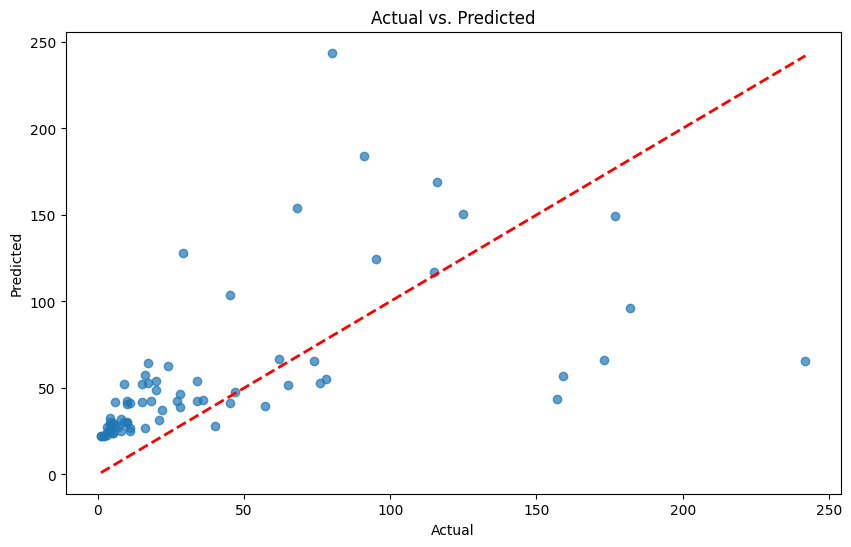

In [64]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')
plt.show()


## Conclusion
The Gradient Boosting model, optimized using Grid Search Cross-Validation, demonstrates some predictive capability but remains limited in effectiveness. The final model produced the following performance metrics:

Mean Squared Error (MSE): 2290.98
R² Score: 0.16
These results indicate that while the model has improved over previous iterations, it still explains only 16% of the variance in the target variable, suggesting that it is not fully capturing the underlying patterns in the data. The relatively high MSE also indicates that there is still significant room for improvement in prediction accuracy.